In [1]:
%%capture
!pip install -r requirements.txt

In [63]:
import pandas as pd
import json
import glob
import itertools
import numpy as np
from collections import defaultdict
from scipy.stats import zscore
import requests
import gdown
from datetime import timedelta
import re

In [239]:
data_folder = '../data'
output_folder = '../output'

## Open Deception

Downloaded from Rada Mihalcea's [website](https://web.eecs.umich.edu/~mihalcea/downloads.html), based on her open-domain deception paper.

In [4]:
input_file = f'{data_folder}/OpenDeception/7Truth7LiesDataset.csv'
df = pd.read_csv(input_file, quotechar="'", escapechar="\\")
df.head()

,id,_gender,age,education,country,text,class
0,1_f_l_1,Female,26,Bachelors degree,Canada,There is a great deal of truth to the anti-vax...,lie
1,1_f_l_2,Female,26,Bachelors degree,Canada,Jenny mccarthy is a learned doctor who deserve...,lie
2,1_f_l_3,Female,26,Bachelors degree,Canada,Driving doesn't really require any practice.,lie
3,1_f_l_4,Female,26,Bachelors degree,Canada,Drinking and driving is a winning and safe com...,lie
4,1_f_l_5,Female,26,Bachelors degree,Canada,Good hygiene isn't really important or attract...,lie


In [3]:
data = {}
data['lie'] = list(df[df['class']=='lie']['text']) # positive denotes lie
data['truth'] = list(df[df['class']=='truth']['text']) # negative denotes truth

In [4]:
output = {
    'distributions':data,
    'note':'',
    'description':'Lies and truths from any domain generated via crowdsourcing.'
}
output_file = f'{output_folder}/open_deception.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## Fake News

Downloaded from Rada Mihalcea's [website](https://web.eecs.umich.edu/~mihalcea/downloads.html), based on her fake news paper.

In [5]:
files = glob.glob(f'{data_folder}/fakeNewsDatasets/fakeNewsDataset/**/*.txt')
legit, fake = [], []
for file in files:
    with open(file, 'r') as f:
        contents = f.read()
        if 'legit' in file:
            legit.append(contents)
        else:
            fake.append(contents)

In [12]:
data = {}
data['legit'] = legit
data['fake'] = fake

In [14]:
output = {
    'distributions':data,
    'note':'',
    'description':'Crowdsourced news articles from various domains.'
}
output_file = f'{output_folder}/fake_news.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## Real Life Deception

Downloaded from Rada Mihalcea's [website](https://web.eecs.umich.edu/~mihalcea/downloads.html), based on her real life deception paper.

In [6]:
files = glob.glob(f'{data_folder}/RealLifeDeception/Transcription/**/*.txt')
truth, lie = [], []
for file in files:
    with open(file, 'r') as f:
        contents = f.read()
        if 'truth' in file:
            truth.append(contents)
        else:
            lie.append(contents)

In [8]:
data = {}
data['truth'] = truth # lie
data['lie'] = lie # truth

In [9]:
output = {
    'distributions':data,
    'note':'',
    'description':'Deception from criminal justice cases.'
}
output_file = f'{output_folder}/real_life_deception.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## Football

Taken from Merullo et al.'s Football Commentary [dataset](https://arxiv.org/abs/1909.03343).

In [18]:
input_file = f'{data_folder}/football/football_15.json'
with open(input_file, 'r') as f:
    js_data = json.load(f)

In [19]:
white, nonwhite = [], []
for instance in js_data.values():
    race = instance['label']['race']
    commentary = ' '.join(instance['mention']).replace('<player>', 'the player')
    if race == 'white':
        white.append(commentary)
    else:
        nonwhite.append(commentary)

In [20]:
data = {}
data['white'] = white # white
data['nonwhite'] = nonwhite # nonwhite
output = {
    'distributions':data,
    'note':'',
    'description':'Live football commentary on players by race.'
}
output_file = f'{output_folder}/football.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## Professor Gender 1

Pulled from preprocessed RateMyProfessor text.

In [2]:
input_file = f'{data_folder}/profgender/full-data.txt'
df = pd.read_csv(input_file)

In [3]:
data = {}
data['woman'] = list(df[df['Professor Gender']=='W']['Comment Text']) # woman
data['man'] = list(df[df['Professor Gender']=='M']['Comment Text']) # man

In [17]:
output = {
    'distributions':data,
    'note':'',
    'description':'RateMyProfessor comments on male and female professors.'
}
output_file = f'{output_folder}/prof_gender.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## Professor Gender 2

In [33]:
df = pd.DataFrame()
files = glob.glob(f'{data_folder}/ratemyprof/*.csv')
for file in files:
    df = df.append(pd.read_csv(file))

In [34]:
import gender_guesser.detector as gender
d = gender.Detector()
get_gender = lambda name: d.get_gender(name)

In [35]:
df['first_name'] = df['prof_name'].str.split().str[0]
df['gender'] = df['first_name'].apply(get_gender)
df['gender'].value_counts()

male             86699
female           40619
unknown          11741
mostly_male       4724
mostly_female     4639
andy              1710
Name: gender, dtype: int64

In [47]:
data = {}
df = df.sample(frac=1, random_state = 0)
data['female'] = list(map(str, df[df['gender']=='female']['text'])) # woman
data['male'] = list(map(str, df[df['gender']=='male']['text'])) # man

In [51]:
data['female'] = [t for t in data['female'] if ' him ' not in t and ' his ' not in t]
data['male'] = [t for t in data['male'] if 'she' not in t and ' her ' not in t]

In [52]:
output = {
    'distributions':data,
    'note':'',
    'description':'RateMyProfessor comments on male and female professors.'
}
output_file = f'{output_folder}/prof_gender.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## Parenting Topics

Read sentences pulled from various parenting topics from [Gao et al.](https://dl.acm.org/doi/10.1145/3411764.3445203).

In [64]:
input_file = f'{data_folder}/parenting/0527_reddit_1300_parenting_clean.csv'
df = pd.read_csv(input_file)
df.head()

,text,label,topics
0,So I participated in the survey re: exclusive ...,1,breastfeeding
1,I've started researching what pumps my insuran...,1,breastfeeding
2,Three and a half year old while listening to E...,1,NaN
3,"About a week ago, my 2 1/2 year old started co...",1,"economy,child product"
4,When is it positive to say your kid does not l...,1,NaN


In [65]:
df = df.dropna()
topics = set(itertools.chain.from_iterable(df['topics'].str.split(',')))
data = {}
for topic in topics:
    data[topic] = list(df[df['topics'].str.contains(topic)]['text'].apply(lambda s: s.replace(u"\u2018", "'").replace(u"\u2019", "'")))

In [66]:
output = {
    'distributions':data,
    'note':'',
    'description':'Parenting discussions on Reddit.'
}
output_file = f'{output_folder}/parenting.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## Parenting Users

Using original source data.

In [2]:
output = f'{data_folder}/parenting/labeled_posts.csv'

In [6]:
id = '1GpYLez_wxJWiYQ3F6nDJLH7ymdaGsI87'
url = f'https://drive.google.com/uc?id={id}'
gdown.download(url, output)

Downloading...
From: https://drive.google.com/uc?id=1GpYLez_wxJWiYQ3F6nDJLH7ymdaGsI87
To: /Users/peterzhang/Documents/GitHub/diff_dist/data/parenting/labeled_posts.csv
100%|██████████| 669M/669M [00:18<00:00, 36.8MB/s] 


'data/parenting/labeled_posts.csv'

In [3]:
df = pd.read_csv(output)

In [4]:
df = df.sample(frac=1, random_state=0) # shuffle
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

In [5]:
first_post = df[['author', 'datetime']].groupby('author').min()
get_first_post = dict(zip(first_post.index, first_post['datetime']))
df['first_post'] = df['author'].apply(lambda x: get_first_post[x])
df['age'] = df['datetime'] - df['first_post']

In [6]:
labels = ['new', '30 days', '90 days', 'half year', '1 year', '2 years', '3 years', '4 years', '5 years']
days = (0, 30, 90, 180, 365, 2*365, 3*365, 4*365, 5*365, 100*365) # first 90 days, first year, first three years
bins = [timedelta(days=d) for d in days]
df['stage'] = pd.cut(df['age'], bins=bins, right=False, labels=labels)
df['stage'].value_counts()

new          268421
half year     83370
90 days       73844
30 days       72817
1 year        57341
2 years       23824
3 years       12922
4 years        7903
5 years        1636
Name: stage, dtype: int64

In [7]:
data = {}
for stage in labels:
    data[stage] = list(df[df['stage'] == stage]['selftext'])[:3000]

In [8]:
output = {
    'distributions':data,
    'note':'',
    'description':'Parenting discussions at different stages of parenting.'
}
output_file = f'{output_folder}/parenting_stages.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

In [9]:
mom_subreddits = ('Mommit', 'NewMomStuff')
dad_subreddits = ('daddit', 'NewDads')
is_mom = df[['author', 'subreddit']].groupby('author').agg(lambda x: x.isin(mom_subreddits).any())
is_dad = df[['author', 'subreddit']].groupby('author').agg(lambda x: x.isin(dad_subreddits).any())

In [10]:
get_is_mom = dict(zip(is_mom.index, is_mom['subreddit']))
get_is_dad = dict(zip(is_dad.index, is_dad['subreddit']))
df['is_mom'] = df['author'].apply(lambda x: get_is_mom[x])
df['is_dad'] = df['author'].apply(lambda x: get_is_dad[x])

In [11]:
data = {}
data['moms'] = list(df[df['is_mom'] & ~df['is_dad'] & ~df['subreddit'].isin(mom_subreddits)]['selftext'])
data['dads'] = list(df[df['is_dad'] & ~df['is_mom'] & ~df['subreddit'].isin(dad_subreddits)]['selftext'])

In [12]:
output = {
    'distributions':data,
    'note':'',
    'description':'Parenting discussions by gender.'
}
output_file = f'{output_folder}/parenting_genders.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

In [35]:
counts = df['author'].value_counts()
frequent_authors = list(counts.index[counts > 100])[2:] # exclude AutoModerator and [deleted]
data = {}
for author in frequent_authors:
    data[author] = list(df[df['author'] == author]['selftext'])

In [36]:
output = {
    'distributions':data,
    'note':'',
    'description':'Parenting discussions by user.'
}
output_file = f'{output_folder}/parenting_users.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## Polarization

From Jerry Wei's news slant [dataset](https://github.com/JerryWei03/NewB).

In [50]:
data = {}
lib_file = f'{data_folder}/NewB-master/liberal.txt'
with open(lib_file, 'r') as file:
    data['lib'] = list(map(lambda x: x[2:], file.readlines()))
con_file = f'{data_folder}/NewB-master/conservative.txt'
with open(con_file, 'r') as file:
    data['con'] = list(map(lambda x: x[2:], file.readlines()))


In [22]:
output = {
    'distributions':data,
    'note':'',
    'description':'News slant dataset on articles about Donald Trump.'
}
output_file = f'{output_folder}/news_slant.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## Ukraine Bias

Annotated data from [Farber et al.](https://github.com/michaelfaerber/ukraine-news-bias) on news coverage during the Ukraine crisis.

In [23]:
input_file = f'{data_folder}/ukraine/sentences-with-binary-labels-bias.csv'
df = pd.read_csv(input_file, header=None)
df.head()

,0,1
0,Russia claims thousands fleeing Ukraine,0
1,"Russia says 143,000 Ukrainians have already le...",0
2,Thousands of Ukrainians are fleeing across the...,0
3,"According to the border services, since the be...",0
4,The head of the citizenship department of the ...,0


In [24]:
data = {}
data['bias'] = list(df[df[1]==1][0])
data['no bias'] = list(df[df[1]==0][0])

In [26]:
output = {
    'distributions':data,
    'note':'',
    'description':'Recent articles about Ukraine labeled for subjectiveness.'
}
output_file = f'{output_folder}/ukraine.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## Essays

Automated essay scoring [data](https://www.kaggle.com/c/asap-aes/data?select=training_set_rel3.xlsx) from the Hewlett Foundaiton.

In [240]:
input_file = f'{data_folder}/papers/training_set_rel3.tsv'
df = pd.read_csv(input_file, sep='\t', encoding='latin-1')

In [244]:
df[df['essay_set'] == 5].domain1_score.value_counts()

2    649
3    572
1    302
4    258
0     24
Name: domain1_score, dtype: int64

In [29]:
mean=df.groupby('essay_set').domain1_score.transform('mean')    
std=df.groupby('essay_set').domain1_score.transform('std')
df['z_score'] = (df['domain1_score'] - mean)/std

In [30]:
data = {}
data['bad'] = list(df[df['z_score'] < 0]['essay'])
data['good'] = list(df[0 <= df['z_score']]['essay'])

In [31]:
output = {
    'distributions':data,
    'note':'',
    'description':'Set of essays answering 6 prompts with scores, divided into top and bottom half.'
}
output_file = f'{output_folder}/essays.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## Diplomacy

From the [Diplomacy project](https://sites.google.com/view/qanta/projects/diplomacy) dataset.

In [32]:
files = glob.glob(f'{data_folder}/diplomacy/*.json')
data = {}
data['truth'] = []
data['lie'] = []
for file in files:
    df = pd.read_json(file, lines=True)
    messages = list(itertools.chain.from_iterable(pd.read_json(files[0], lines=True)['messages']))
    labels = list(itertools.chain.from_iterable(pd.read_json(files[0], lines=True)['sender_labels']))
    df = pd.DataFrame({'message':messages, 'label':labels})
    data['truth'].extend(list(df[df['label']==True]['message']))
    data['lie'].extend(list(df[df['label']==False]['message']))

In [33]:
output = {
    'distributions':data,
    'note':'',
    'description':'Commentary from games of Diplomacy labeled for deceptiveness.'
}
output_file = f'{output_folder}/diplomacy.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## News Headlines

From the ABC "million news headlines" [dataset](https://www.kaggle.com/therohk/million-headlines), "spam clickbait catalog" [dataset](https://www.kaggle.com/therohk/examine-the-examiner), and India news headlines [dataset](https://www.kaggle.com/therohk/india-headlines-news-dataset).

In [15]:
headline_files = [
    (f'{data_folder}/abc_headlines/abcnews-date-text.csv', f'{output_folder}/abc_headlines.json', "ABC"),
    (f'{data_folder}/examiner_headlines/examiner-date-text.csv', f'{output_folder}/examiner_headlines.json', "The Examminer"),
    (f'{data_folder}/india_headlines/india-news-headlines.csv', f'{output_folder}/india_headlines.json', "India news")
]
for input_file, output_file, outlet in headline_files:
    df = pd.read_csv(input_file)
    df['year'] = df['publish_date'].astype(str).str[:4].astype(int)
    data = {}
    for year in df['year'].unique():
        data[str(year)] = list(df[df['year']==year]['headline_text'])[:1000]
    output = {
        'distributions':data,
        'note':'',
        'description':f'Headlines from {outlet}'
    }
    with open(output_file, 'w') as outfile:
        json.dump(output, outfile)

## Search Relevance

From the "Home Depot Product Search Relevance" [dataset](https://www.kaggle.com/c/home-depot-product-search-relevance/data?select=train.csv.zip).

In [36]:
input_file = f'{data_folder}/search_relevance/train.csv'
df = pd.read_csv(input_file)

In [37]:
data = {}
data['low relevance'] = list(df[df['relevance'] < 2.5]['search_term'])
data['high relevance'] = list(df[df['relevance'] >= 2.5]['search_term'])

In [39]:
output = {
    'distributions':data,
    'note':'',
    'description':'Home Depot product searches labeled for the relevance of search results.'
}
output_file = f'{output_folder}/search_relevance.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## Product Reviews

Reviews of products from Jianmo Ni's [Amazon Review Data](https://nijianmo.github.io/amazon/index.html#complete-data) dataset.

In [67]:
review_files = [
    (f'{data_folder}/amazon_reviews/AMAZON_FASHION_5.json',f'{output_folder}/amazon_fashion_reviews.json', 'fashion products'),
    (f'{data_folder}/amazon_reviews/All_Beauty_5.json',f'{output_folder}/beauty_reviews.json', 'beauty products'),
    (f'{data_folder}/amazon_reviews/Appliances_5.json',f'{output_folder}/appliances_reviews.json', 'appliances'),
    (f'{data_folder}/amazon_reviews/Arts_Crafts_and_Sewing_5.json',f'{output_folder}/arts_crafts_reviews.json', 'arts and crafts products'),
    (f'{data_folder}/amazon_reviews/Cell_Phones_and_Accessories_5.json',f'{output_folder}/phone_reviews.json', 'phones'),
    (f'{data_folder}/amazon_reviews/Automotive_5.json',f'{output_folder}/automotive_reviews.json', 'automative products')
]
for input_file, output_file, product in review_files:
    print(input_file)
    df = pd.read_json(input_file, lines=True)
    data = {}
    for rating in df['overall'].unique():
        data[str(rating)] = list(df[df['overall'] == rating]['reviewText'].astype(str))
    output = {
        'distributions':data,
        'note':'',
        'description':f'Dataset of reviews of {product} on Amazon.'
    }
    with open(output_file, 'w') as outfile:
        json.dump(output, outfile)

data/amazon_reviews/AMAZON_FASHION_5.json
data/amazon_reviews/All_Beauty_5.json
data/amazon_reviews/Appliances_5.json
data/amazon_reviews/Arts_Crafts_and_Sewing_5.json
data/amazon_reviews/Cell_Phones_and_Accessories_5.json
data/amazon_reviews/Automotive_5.json


## Mafia Deception

In [41]:
input_file = f'{data_folder}/mafia/docs.pkl'
df = pd.read_pickle(input_file, 'gzip')

In [42]:
data = {}
data['scum'] = list(df[df['scum']]['content'])[:1000]
data['not scum'] = list(df[~df['scum']]['content'])[:1000]

In [43]:
output = {
    'distributions':data,
    'note':'',
    'description':'Commentary from games of Mafia labeled for deception.'
}
output_file = f'{output_folder}/mafia_deception.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## Stocks Reddit

From ["Daily News for Stock Market Prediction."](https://www.kaggle.com/datasets/aaron7sun/stocknews)

In [44]:
input_file = f'{data_folder}/stocks_reddit/Combined_News_DJIA.csv'
df = pd.read_csv(input_file)

In [45]:
data = {}
data['down'] = []
data['up'] = []
for col in df.columns:
    if "Top" in col:
        data['down'].extend(list(df[df['Label'] == 0][col]))
        data['up'].extend(list(df[df['Label'] == 1][col]))

In [46]:
output = {
    'distributions':data,
    'note':'',
    'description':'Reddit headlines on days where markets rose vs fell.'
}
output_file = f'{output_folder}/reddit_stocks.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## Unhealthy Conversations

From the [Unhealthy Comments Corpus](https://github.com/conversationai/unhealthy-conversations).

In [47]:
files = glob.glob(f'{data_folder}/unhealthy_convo/*.csv')
data = defaultdict(list)
attributes = ['antagonize', 'condescending', 'dismissive', 'generalisation', 'generalisation_unfair', 'healthy', 'hostile', 'sarcastic']
for file in files:
    df = pd.read_csv(file)
    for attr in attributes:
        data[attr].extend(list(df[df[attr] == 1]['comment']))
        data['not_' + attr].extend(list(df[df[attr] == 0]['comment']))

In [48]:
output = {
    'distributions':data,
    'note':'',
    'description':'Unhealthy comments scraped from Reddit labeled by attribute.'
}
output_file = f'{output_folder}/unhealthy_convo.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## Facebook Posts

From the [2012-2016 Facebook Posts](https://data.world/martinchek/2012-2016-facebook-posts/workspace) dataset.

In [49]:
pagenames_file = f'{data_folder}/facebook_posts/fb_news_pagenames.csv'
pagenames_df = pd.read_csv(pagenames_file)
pagenames_dict = dict(zip(pagenames_df['page_id'], pagenames_df['page_name']))

In [50]:
input_file = f'{data_folder}/facebook_posts/fb_news_posts_20K.csv'
df = pd.read_csv(input_file)
df['page_name'] = df['page_id'].apply(lambda x: pagenames_dict[x])

,created_time,description,link,message,page_id,post_id,react_angry,react_haha,react_like,react_love,react_sad,react_wow,scrape_time,shares,page_name
0,2017-07-14T14:30:59+0000,NaN,https://www.facebook.com/bbcnews/videos/101548...,We are #LIVE outside the National Rifle Associ...,228735667216,228735667216_10154890879532217,54,24,993,144,12,24,2017-07-14 11:01:24.379857,139,bbc
1,2017-07-14T14:20:59+0000,,http://bbc.in/2talMsx,UPDATE: \r\n-2 Ukrainian tourists killed in st...,228735667216,228735667216_10154890968202217,172,8,994,11,783,264,2017-07-14 11:01:24.379857,680,bbc
2,2017-07-14T13:40:38+0000,NaN,https://www.facebook.com/bbcnews/videos/101548...,Proms: Come with us on a tour of the Royal Alb...,228735667216,228735667216_10154890852247217,5,12,2034,369,6,45,2017-07-14 11:01:24.379857,395,bbc
3,2017-07-14T12:55:45+0000,NaN,https://www.facebook.com/bbcnews/videos/142678...,Thousands say their final goodbyes to Bradley ...,228735667216,228735667216_1426789250735491,6,0,2262,754,1989,11,2017-07-14 11:01:24.379857,542,bbc
4,2017-07-14T12:45:00+0000,NaN,https://www.facebook.com/bbcnews/videos/101548...,"Despite safety warnings, this beach near an ai...",228735667216,228735667216_10154890645702217,65,513,4336,54,128,815,2017-07-14 11:01:24.379857,1956,bbc


In [51]:
data = {}
for page in pagenames_dict.values():
    data[page] = list(df[df['page_name'] == page]['message'])

In [52]:
output = {
    'distributions':data,
    'note':'',
    'description':'Dataset of Facebook posts from pages of varoius news outlets.'
}
output_file = f'{output_folder}/fb_posts.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## Yelp Reviews

Read subset of Yelp reviews. Add unziped [Yelp dataset](https://www.yelp.com/dataset/documentation/main) to the data folder.

In [53]:
reviews_file = f'{data_folder}/yelp_dataset/yelp_academic_dataset_review.json'
business_file = f'{data_folder}/yelp_dataset/yelp_academic_dataset_business.json'

In [54]:
reviews_df = pd.read_json(reviews_file, lines=True, nrows=100000)
business_df = pd.read_json(business_file, lines=True, nrows=100000)

Explore potential restaurant types.

In [55]:
reviews_df = reviews_df.merge(business_df[['business_id', 'categories']], on='business_id', how='left')
reviews_df = reviews_df[reviews_df['categories'].apply(lambda x: bool(x) and 'Restaurants' in x)]

In [56]:
restaurant_types = {
    'Pizza':'pizza',
    'Mexican':'mexican',
    'Chinese':'chinese',
    'Italian':'italian',
    'American (New)':'new_american',
    'American (Traditional)':'trad_american',
    'Thai':'thai',
    'Vietnamese':'vietnamese',
    'Seafood':'seafood',
    'Barbeque':'bbq',
    'Diners':'diner',
    'Japanese':'japanese'
}
for category, keyword in restaurant_types.items():
    reviews_df['is_' + keyword] = reviews_df['categories'].apply(lambda x: bool(x) and category in x)

In [57]:
data = {}
for keyword in restaurant_types.values():
    data[keyword] = list(reviews_df[reviews_df['is_' + keyword]]['text'])

In [58]:
output = {
    'distributions':data,
    'note':'',
    'description':'Reviews of Yelp restaurants categorized by restaurant type.'
}
output_file = f'{output_folder}/yelp_reviews.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## Reddit Dataset

In [59]:
files = glob.glob(f'{data_folder}/reddit-dataset/*.csv')
header = ['text', 'id', 'subreddit', 'meta', 'time', 'author', 'ups', 'downs', 'authorlinkkarma', 'authorcommentkarma', 'authorisgold']
reddit_df = pd.DataFrame()
malformed =  ('anime', 'comicbooks', 'movies', 'harrypotter')
for file in files:
    sub_df = pd.read_csv(file)
    if any([sub in file for sub in malformed]):
        sub_df = sub_df.iloc[1:, 1:]
    sub_df = sub_df.drop(sub_df.columns[0], axis=1)
    sub_df = sub_df.rename(dict(zip(sub_df.columns, header)), axis=1)
    reddit_df = reddit_df.append(sub_df)

In [60]:
reddit_df['datetime'] = pd.to_datetime(reddit_df['time'], unit='s')

In [61]:
sub_data = {}
for sub in reddit_df['subreddit'].unique():
    sub_df = reddit_df[reddit_df.subreddit == sub]
    days = (max(sub_df.time) - min(sub_df.time))/3600/24
    sub_data[sub] = list(sub_df['text'])[:8000]

In [62]:
output = {
    'distributions':sub_data,
    'note':'',
    'description':'Reddit comments from various subreddits.'
}
output_file = f'{output_folder}/reddit_posts.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## Authorship

In [7]:
files = glob.glob(f'{data_folder}/C50/**/**/*.txt')
data = defaultdict(list)
for file in files:
    author = file.split('/')[3]
    with open(file, 'r') as f:
        text = f.read()
        data[author].append(text)

In [10]:
output = {
    'distributions':data,
    'note':'',
    'description':'Texts by various Reuters authors on similar topics.'
}
output_file = f'{output_folder}/reuters_authors.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## Misspelling

Sentiment140 dataset with [1.6M Tweets](https://www.kaggle.com/datasets/kazanova/sentiment140).

In [2]:
path = f'{data_folder}/covid_tweets/training.csv'
df = pd.read_csv(path, names=['id', 'timstamp', 'type', 'user', 'text'], encoding='latin-1')

In [19]:
normalization_pairs = [
    ('your', [' ur '], [' your ', ' you\'re ']),
    ('with', [' wit '], [' with ']),
    ('that', [' dat ', ' dats '], [' that ']),   
    ('going', [' goin '], ['going ']),
    ('know', [' kno '], [' know ']),
    ('you', [' u '], [' you ']),
    ('what', [' wut ', ' wat '], [' what ']),
    ('the', [' da '], [' the '])
]

In [20]:
data = {}
for group, misspell, proper in normalization_pairs:
    data[group + '_misspell'] = list(df[df['text'].str.contains('|'.join(misspell))]['text'])
    data[group + '_proper'] = list(df[df['text'].str.contains('|'.join(proper))]['text'])

In [84]:
output = {
    'distributions':data,
    'note':'',
    'description':'Tweets with and without mispellings of common words.'
}
output_file = f'{output_folder}/tweet_misspellings.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## Reddit Humor

From the [Reddit Humor Detection](https://github.com/orionw/RedditHumorDetection) dataset.

In [14]:
files = ['dev.tsv', 'train.tsv']
df = pd.DataFrame()
for f in files:
    path = f'{data_folder}/reddithumor/{f}'
    df = df.append(pd.read_csv(path, names=['index', 'funny', 'type', 'text'], encoding='latin-1'))
df = df.drop(['index', 'type'], axis=1)

In [18]:
data = {}
def process(text):
    return text.replace('_____', ' ')
data['funny'] = list(df[df['funny'] == 1]['text'].apply(process))
data['unfunny'] = list(df[df['funny'] == 0]['text'].apply(process))

In [20]:
output = {
    'distributions':data,
    'note':'',
    'description':'Funny and unfunny Reddit jokes, as judged by proportion of upvotes.'
}
output_file = f'{output_folder}/reddit_jokes.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## ECHR

The [ECHR dataset](https://archive.org/details/ECHR-ACL2019).

In [111]:
path = '{data_folder}/ECHR_Dataset/*_Anon/*.json'
files = glob.glob(path)
dicts = [json.load(open(f, 'r')) for f in files]

In [117]:
np.random.seed(0)
data = defaultdict(list)
for d in np.random.permutation(dicts)[:1000]:
    text = '\n'.join(d['TEXT'])
    if d['VIOLATED_ARTICLES']:
        data['violation'].append(text)
    else:
        data['no_violation'].append(text)
data = dict(data)

In [50]:
output = {
    'distributions':data,
    'note':'',
    'description':'Court decisions of the ECHR, categorized by whether there was a violation.'
}
output_file = f'{output_folder}/echr_decisions.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## SCOTUS Decisions

In [55]:
path = f'{data_folder}/scotus/task1_data.pkl'
df = pd.read_pickle(path)

In [56]:
df.rename(columns={'Facts': 'facts'}, inplace=True)
df.drop(columns=['index'], inplace=True)
df.reset_index(inplace=True)

In [57]:
df_mirror = df.copy()
df_mirror[['second_party', 'first_party']] = df_mirror[['first_party', 'second_party']]
df = df.append(df_mirror)

In [58]:
df['text'] = df['first_party'] + ' ' + df['facts']

In [59]:
df['win'] = df['first_party'] == df['winning_party']

In [60]:
data = {}
data['win'] = list(df[df['win']]['text'])
data['lose'] = list(df[~df['win']]['text'])

In [61]:
output = {
    'distributions':data,
    'note':'',
    'description':'Winners and losers of SCOTUS cases with facts, mirrored from each party\s perspective.'
}
output_file = f'{output_folder}/scotus_decisions.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## News Popularity

In [95]:
path = f'{data_folder}/news_pop/News_Final.csv'
df = pd.read_csv(path)

In [122]:
def top_bottom(group, col, n = 50):
    sorted = group.sort_values(col)
    return sorted.iloc[-n:], sorted.iloc[:n]

def clean_text(text):
    return str(text).replace('&quot;', '"').replace('"""', '"')

df['Headline'] = df['Headline'].apply(clean_text)
df['Title'] = df['Title'].apply(clean_text)

def rank_sentiment(group):
    return top_bottom(group, 'SentimentTitle')

def rank_fb(group):
    return top_bottom(group, 'Facebook')

In [123]:
sentiment_groups = df.groupby('Topic').apply(rank_sentiment)
data = {}
for topic in sentiment_groups.keys():
    pos, neg = sentiment_groups[topic]
    data[topic + '_pos'] = list(pos['Title'])
    data[topic + '_neg'] = list(neg['Title'])

In [124]:
fb_df = df[(df.Source == 'Bloomberg') & (df.Facebook >= 0) & (df.Topic.isin(['obama', 'economy', 'microsoft']))]
fb_groups = fb_df.groupby('Topic').apply(rank_fb)
for topic in fb_groups.keys():
    pop, unpop = fb_groups[topic]
    data[topic + '_pop'] = list(pop['Title'])
    data[topic + '_unpop'] = list(unpop['Title'])

In [125]:
output = {
    'distributions':data,
    'note':'',
    'description':'Headlines on four topics with social feedback on four platforms.'
}
output_file = f'{output_folder}/news_pop.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## Convincingness

In [150]:
data_path = f'{data_folder}/convincingness/*'
files = glob.glob(data_path)
df = pd.DataFrame(columns=['id', 'rank', 'argument'])
def read_file(file):
    f = open(file, 'r')
    lines = f.readlines()
    data = []
    for line in lines[1:]:
        id, rank, argument = line.split('\t')
        data.append([id, rank, argument])
    return pd.DataFrame(data, columns=['id', 'rank', 'argument'])
for file in files:
    df = df.append(read_file(file))

In [189]:
def top_bottom(group, col, n = 50):
    sorted = group.sort_values(col)
    return sorted.iloc[-n:], sorted.iloc[:n]

data = {}
unconvincing, convincing = top_bottom(df, 'rank', 500)
data['unconvincing'] = unconvincing
data['convincing'] = convincing

In [190]:
output = {
    'distributions':data,
    'note':'',
    'description':'Arguments on online forums ranked by convincingness.'
}
output_file = f'{output_folder}/convincingness.json'
with open(output_file, 'w') as outfile:
    json.dump(output, outfile)

## Open Review

In [6]:
import openreview
client = openreview.Client(baseurl='https://api.openreview.net')

In [233]:
invites = [
    (2018, 'ICLR.cc/2018/Conference/-/Blind_Submission','ICLR.cc/2018/Conference/-/Paper.*/Official_Review'),
    (2019, 'ICLR.cc/2019/Conference/-/Blind_Submission','ICLR.cc/2019/Conference/-/Paper.*/Official_Review'),
    (2020, 'ICLR.cc/2020/Conference/-/Blind_Submission','ICLR.cc/2020/Conference/Paper.*/-/Official_Review'),
    (2021, 'ICLR.cc/2021/Conference/-/Blind_Submission','ICLR.cc/2021/Conference/Paper.*/-/Official_Review'),
]

metadata = []

for year, submission_invite, review_invite in invites:

    submissions = openreview.tools.iterget_notes(
        client, invitation=submission_invite)
    submissions_by_forum = {n.forum: n for n in submissions}

    reviews = openreview.tools.iterget_notes(
        client, invitation=review_invite)
    reviews_by_forum = defaultdict(list)
    for review in reviews:
        reviews_by_forum[review.forum].append(review)

    for forum in submissions_by_forum:

        forum_reviews = reviews_by_forum[forum]
        review_ratings = [int(n.content['rating'][0]) for n in forum_reviews]
        average_rating = np.mean(review_ratings)

        submission_content = submissions_by_forum[forum].content
        abstract = submission_content['abstract']

        forum_metadata = {
            'forum': forum,
            'review_ratings': review_ratings,
            'average_rating': average_rating,
            'abstract': abstract,
            'year': year,
        }
        metadata.append(forum_metadata)

In [234]:
df = pd.DataFrame(metadata)

In [236]:
df[df.average_rating >= 5].abstract.tolist()
df[df.average_rating < 5].abstract.tolist()

,forum,review_ratings,average_rating,abstract,year
0,ryBnUWb0b,"[7, 6, 6]",6.333333,"In cities with tall buildings, emergency respo...",2018
1,Skk3Jm96W,"[7, 4, 6]",5.666667,We consider the problem of exploration in meta...,2018
2,r1RQdCg0W,"[6, 6, 6]",6.000000,We present Merged-Averaged Classifiers via Has...,2018
3,rJ3fy0k0Z,"[6, 5, 5]",5.333333,The goal of imitation learning (IL) is to enab...,2018
4,SkBYYyZRZ,"[5, 4, 7]",5.333333,The choice of activation functions in deep net...,2018
...,...,...,...,...,...
7133,Dh29CAlnMW,"[4, 4, 6]",4.666667,The Automunge open source python library platf...,2021
7134,Ig-VyQc-MLK,"[6, 7, 4, 9]",6.500000,Recent work has explored the possibility of pr...,2021
7135,EXkD6ZjvJQQ,"[6, 6, 7]",6.333333,This paper investigates the finite-sample pred...,2021
7136,QjINdYOfq0b,"[6, 4, 6]",5.333333,We present Automatic Bit Sharing (ABS) to auto...,2021


In [246]:
pd.read_csv('https://github.com/dbbrandt/short_answer_granding_capstone_project/blob/master/data/source_data/ShortAnswerGrading_v2.0/data/raw/all',sep='1232')

/Users/peterzhang/opt/anaconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


ParserError: Expected 1 fields in line 6326, saw 3. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,...,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,...,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20045,815757572,True,golden,259,NaN,female,1.0000,yes,1.0,8/5/15 21:16,...,https://pbs.twimg.com/profile_images/656793310...,0,C0DEED,"@lookupondeath ...Fine, and I'll drink tea too...",NaN,783,10/26/15 13:20,6.587400e+17,Verona ªÁ,NaN
20046,815757681,True,golden,248,NaN,male,1.0000,yes,1.0,8/15/12 21:17,...,https://pbs.twimg.com/profile_images/639815429...,0,0,Greg Hardy you a good player and all but don't...,NaN,13523,10/26/15 12:40,6.587300e+17,"Kansas City, MO",NaN
20047,815757830,True,golden,264,NaN,male,1.0000,yes,1.0,9/3/12 1:17,...,https://pbs.twimg.com/profile_images/655473271...,0,C0DEED,You can miss people and still never want to se...,NaN,26419,10/26/15 13:20,6.587400e+17,Lagos Nigeria,NaN
20048,815757921,True,golden,250,NaN,female,0.8489,yes,1.0,11/6/12 23:46,...,https://pbs.twimg.com/profile_images/657716093...,0,0,@bitemyapp i had noticed your tendency to pee ...,NaN,56073,10/26/15 12:40,6.587300e+17,Texas Hill Country,NaN


In [254]:
!pip install pyreadr

     |████████████████████████████████| 250 kB 3.0 MB/s eta 0:00:01


In [255]:
import pyreadr

In [258]:
result = pyreadr.read_r('corpus_nytimes_summary.Rds')

LibrdataError: Invalid file, or file has unsupported features

In [292]:
files = glob.glob('../manual/BarnumLoNPTReplication/data/docs_by_committee/**/*.txt')
docs = []
for file in files:
    year = re.findall('\d\d\d\d', file)[0]
    with open(file, 'r', encoding='latin1') as f:
        text = " ".join(f.readlines())
    doc = {
        'year':int(year),
        'text':text
    }
    docs.append(doc)

<AxesSubplot:ylabel='Frequency'>

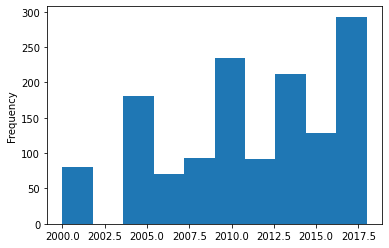

In [291]:
df = pd.DataFrame(docs)
pre_2008 = df[df.year < 2008].text.tolist()
btw_2008_2012 = df[(df.year >= 2008) & (df.year < 2012)].text.tolist()
post_2012 = df[df.year >= 2012]